In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns 
sns.set(style="darkgrid", font_scale=1.2) 
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy.sparse.linalg import svds
data=pd.read_csv('E:\\Essay\\ratings_Books(1).csv')
data.columns =["userID", "itemID", "rating",'timestamp']
data.head(5)
data1 = data.copy()   #使用data1进行操作，避免误触data原数据又要再读取浪费时间
print(data.shape)
print(data.dtypes)
num_test=800000
data_final = data1.iloc[:num_test,0:]
data_final.shape


(22507154, 4)
userID        object
itemID        object
rating       float64
timestamp      int64
dtype: object


(800000, 4)

## 对不同N =100 / 50进行实验
### 在del_index = users_count[users_count<100].index    
### 100换50即可

In [2]:
data_final = data_final.drop(['timestamp'],axis=1)
data_final.head(5)
users_count = data_final.userID.value_counts()

del_index = users_count[users_count<100].index                     #要删除的index=评分个数小于100的用户数据
data_final_1 = data_final[~data_final.userID.isin(del_index)]     
len(data_final_1)
data_final_1.shape

# 得到用户-商品评分矩阵
rating_matrix = data_final_1.pivot(index='userID',columns='itemID',values='rating')
rating_matrix.head()
final_ratings_matrix = rating_matrix.fillna(0)
final_ratings_matrix.head()
# 重新给userID编号,因为data_final_1不存在一个用户给同一本书两次评分，所以形成的用户-商品矩阵的用户不存在重复
final_ratings_matrix.reset_index(drop = True,inplace = True)
final_ratings_matrix.head()

itemID,000077135X,000100039X,0001501232,0001839233,0001847775,0001848062,0001850032,0001850164,0002005395,0002007770,...,0062020161,006202017X,0062020188,0062020447,0062020455,006202048X,0062020560,0062020617,0062020625,0062020633
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
R = final_ratings_matrix.values
R_noised = R
m,n = R.shape
for i in range(m):
    for j in range(n):
        if R[i][j] == 4:
            R_noised[i][j] = 3
R_noised     # R_noised 把评分为4的全扰动成评分为3

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
#用户平均值（行）填充
def fill_with_row_avg(rating_matrix):
    R = rating_matrix.values
    m,n = np.shape(rating_matrix)
    for i in range(m):
        for j in range(n):
            if np.isnan(R[i][j]):
                R[i][j] = np.nanmean(R[i,:])
    R = pd.DataFrame(R)
    return R

In [5]:
def Density(R):
    num_ratings = np.count_nonzero(R)
    #print('given_num_of_ratings = ', num_ratings)

    total_num_ratings = R.shape[0] * R.shape[1]
    #print('possible_num_of_ratings = ', total_num_ratings)

    density = (num_ratings/total_num_ratings)
    density *= 100
    #print ('density: {:4.2f}%'.format(density))
    R.reset_index(drop = True,inplace = True)    
    return density

In [6]:
def Svd(R, K):
    U, sigma, Vt = svds(R.values, K)
    sigma = np.diag(sigma)
    P = np.dot(np.dot(U,sigma),Vt)
    P_df = pd.DataFrame(P,columns=R.columns)
    return P_df

In [7]:
# Recommend the items with the highest predicted ratings
def recommend_item(userID, R, P_df, num_recommendation):

    # Index starts at 0
    user_idx = userID-1
    
    # Get and sort the user's ratings
    sorted_rating = R.iloc[user_idx].sort_values(ascending=False)

    # Sorted_user_predication_ratings
    sorted_user_prediction = P_df.iloc[user_idx].sort_values(ascending=False)

    # Sorted_user_predictions
    recom = pd.concat([sorted_rating, sorted_user_prediction], axis=1)
    recom.index.name = '推荐的商品序号'
    recom.columns = ['用户评分', '预测的用户评分']
    recom = recom.loc[recom.用户评分 == 0]
    recom = recom.sort_values('预测的用户评分', ascending=False)
    
    print('\n以下是对用户(ID = {})推荐的商品:\n'.format(userID))
    print(recom.head(num_recommendation))

In [8]:
def Rmse(R,P_df):
    # 每个商品的实际平均评分
    actual_rating_each_item = R.mean()
    predicted_rating_each_item = P_df.mean()
    rmse_df = pd.concat([R.mean(), P_df.mean()], axis=1)
    rmse_df.columns=['实际平均评分','预测平均评分']
    rmse_df.head()
    rmse = round((((rmse_df.实际平均评分-rmse_df.预测平均评分)**2).mean()**0.5),4)
    return rmse

In [9]:
#扰动 4-->3
rating_matrix_noise = data_final_1.values
m,n = rating_matrix_noise.shape
cnt=0
for i in range(m):
    if rating_matrix_noise[i,2]==4.0:
        rating_matrix_noise[i,2]=3.0  #将分数为4的扰动为3
        cnt=cnt+1
rating_matrix_noise = pd.DataFrame(rating_matrix_noise)
rating_matrix_noise.columns=["userID", "itemID", "rating"]
rating_matrix_noise = rating_matrix_noise.pivot(index='userID',columns='itemID',values='rating')
rating_matrix_noise.head()
print(cnt)

3569


In [10]:
# 0 填充
R_fill_0_noise = rating_matrix_noise.fillna(0)

In [11]:
# 行填充
R = rating_matrix_noise.values
R = np.array(R,float)
m,n = np.shape(rating_matrix_noise)
for i in range(m):
    for j in range(n):
        if np.isnan(R[i][j]):
            R[i][j] = np.nanmean(R[i,:])
R_fill_row_noise = pd.DataFrame(R,columns=rating_matrix_noise.columns)

In [12]:
R_fill_row_noise = pd.DataFrame(R,columns=rating_matrix_noise.columns)
R_fill_row_noise

itemID,000077135X,000100039X,0001501232,0001839233,0001847775,0001848062,0001850032,0001850164,0002005395,0002007770,...,0062020161,006202017X,0062020188,0062020447,0062020455,006202048X,0062020560,0062020617,0062020625,0062020633
0,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,...,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333,4.133333
1,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,...,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385,4.415385
2,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,...,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228,4.277228
3,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,...,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475,4.995475
4,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,...,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037,3.912037
5,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283,3.000000,...,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283,3.732283
6,2.660377,2.660377,2.660377,2.660377,2.660377,2.660377,2.660377,2.660377,2.660377,3.000000,...,2.660377,2.660377,2.000000,2.660377,2.660377,2.660377,2.660377,2.660377,2.660377,2.660377
7,3.415094,3.415094,3.415094,3.415094,3.415094,3.415094,3.415094,3.415094,3.415094,3.415094,...,3.415094,3.415094,5.000000,3.415094,3.415094,3.415094,3.415094,3.415094,3.415094,3.415094
8,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,...,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019,3.628019
9,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,...,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664,3.725664


In [13]:
x = np.array([10,20,30,40,50])
rmse_fill_0 = []
rmse_fill_row = []
iteration = x.shape[0]

In [14]:
# 0  填充
for i in range(iteration):
    K = x[i]
    density = Density(R_fill_0_noise)
    P_df = Svd(R_fill_0_noise,K)
    rmse = Rmse(R_fill_0_noise,P_df)
    rmse_fill_0.append(rmse)
print ('density: {:4.2f}%'.format(density))
print(rmse_fill_0)     

density: 3.19%
[0.0465, 0.0268, 0.0212, 0.0165, 0.0078]


In [15]:
#  行填充
for i in range(iteration):
    K = x[i]
    density = Density(R_fill_row_noise)
    P_df = Svd(R_fill_row_noise,K)
    rmse = Rmse(R_fill_row_noise,P_df)
    rmse_fill_row.append(rmse)
print ('density: {:4.2f}%'.format(density))
print(rmse_fill_row)  

density: 100.00%
[0.0021, 0.0018, 0.0015, 0.0012, 0.0007]


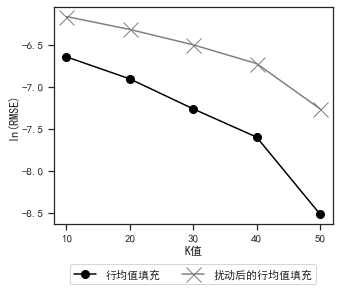

In [16]:
x = [10,20,30,40,50]
y_row = [0.0013, 0.001, 0.0007, 0.0005, 0.0002]
y_row_log = np.log(y_row)
y_row_noise = [0.0021, 0.0018, 0.0015, 0.0012, 0.0007]
y_row_noise_log = np.log(y_row_noise)
plt.figure(figsize=(5,4))

rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(context='notebook', style='ticks', rc=rc)
sns.set_style('ticks')

# 纵坐标使用Log，结果显示更显著
plt.rcParams['axes.unicode_minus'] = False # 用于显示中文 
#plt.title('基于不同相似度的评分预测结果比较')  # 折线图标题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.xlabel('K值')  # x轴标题
plt.ylabel('ln(RMSE)')  # y轴标题

plt.plot(x,y_row_log,marker='o',markersize=8,color='black',label='行均值填充')
plt.plot(x,y_row_noise_log,marker='x',markersize=15,color='grey',label='扰动后的行均值填充')


plt.legend(bbox_to_anchor=(0.5,-0.3),loc=8,ncol=10)

plt.savefig('E:\Essay\CF_SVD_Noise.jpg',dpi=400,bbox_inches='tight')